Step 1: Simulated Data Generation

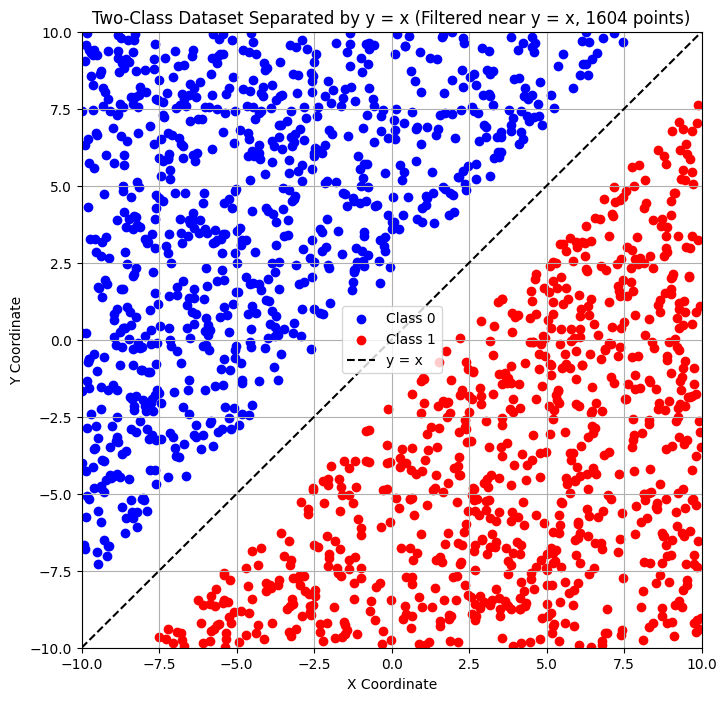

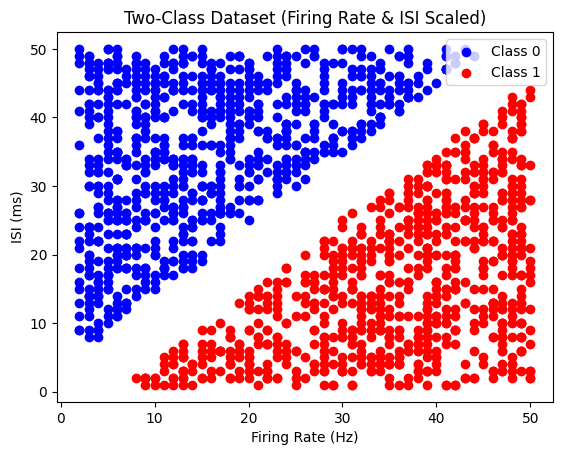

Spike Trains Shape: (1604, 10, 500)
Randomly selected Class 0 index: [1031  830  250  860  280]


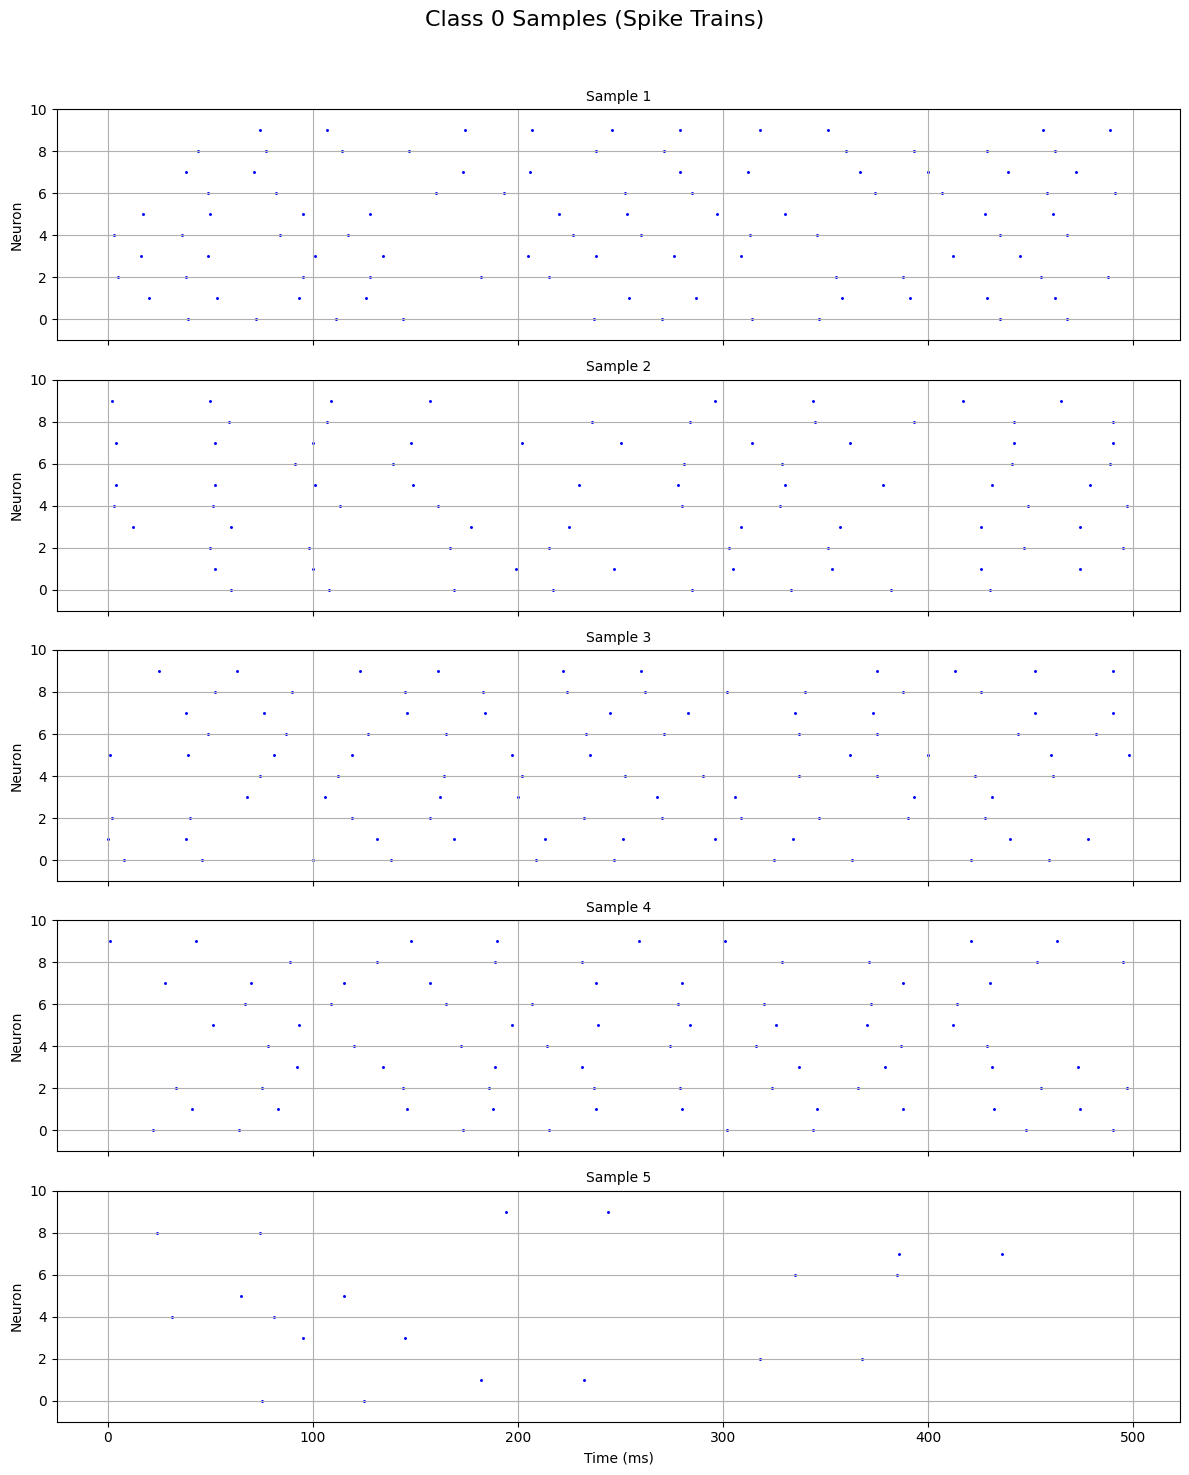

Randomly selected Class 0 index: [1580 1592  320  279 1302]


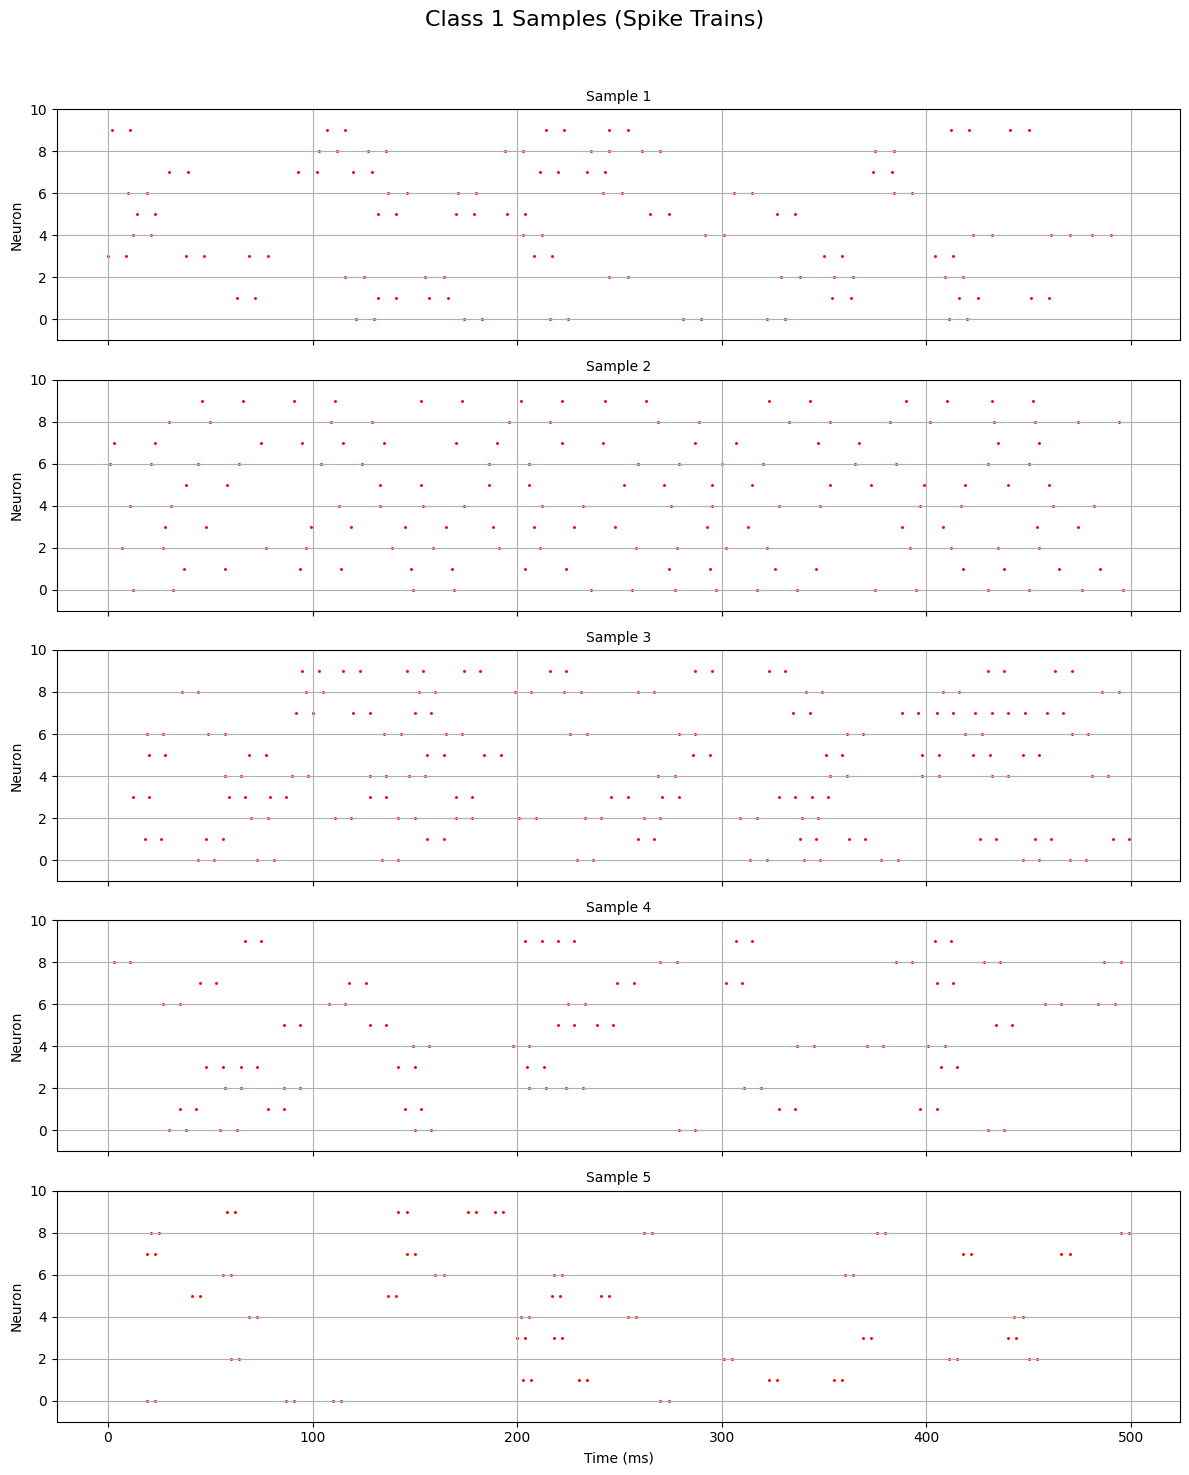

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


# Number of points per class
num_points = 2000  # Increase if you want more total points
radius = 10        # half side of the square [-10,10]x[-10,10]
min_distance = 1.5   # Minimum distance threshold from the line y = x

# 1. Generate random points within a square [-radius, radius]^2
X = np.random.uniform(low=-radius, high=radius, size=(num_points, 2))

# 2. Compute the distance of points to the line y = x
distances = np.abs(X[:, 1] - X[:, 0]) / np.sqrt(2)

# 3. Filter points that satisfy the distance condition
valid_indices = distances >= min_distance
X = X[valid_indices]
num_valid_points = X.shape[0]

# 4. Classify points based on y = x
y = np.where(X[:, 1] > X[:, 0], 0, 1)  # Class 0 if y>x, else Class 1

# 5. Visualize the generated data
plt.figure(figsize=(8, 8))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')

# plot line y=x
plt.plot([-radius, radius], [-radius, radius], color='black', linestyle='--', label='y = x')

plt.xlim(-radius, radius)
plt.ylim(-radius, radius)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Two-Class Dataset Separated by y = x (Filtered near y = x, {num_valid_points} points)')
plt.legend()
plt.grid()
plt.show()

# Map to the integer coordinate range
def linear_map_to_integer(value, old_min, old_max, new_min, new_max):
    mapped = np.round((value - old_min) / (old_max - old_min) * (new_max - new_min) + new_min)
    return np.clip(mapped, new_min, new_max).astype(int)

# Map to specified ranges: firing rate [1, 50] Hz and ISI [1, 50] ms
X_min = X.min(axis=0)
X_max = X.max(axis=0)
firing_rates = linear_map_to_integer(X[:, 0], X_min[0], X_max[0], 2, 50)  # Hz
isis = linear_map_to_integer(X[:, 1], X_min[1], X_max[1], 1, 50)          # ms

# Visualize the data distribution in the mapped range
plt.scatter(firing_rates[y == 0], isis[y == 0], color='blue', label='Class 0')
plt.scatter(firing_rates[y == 1], isis[y == 1], color='red', label='Class 1')
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('ISI (ms)')
plt.legend()
plt.title('Two-Class Dataset (Firing Rate & ISI Scaled)')
plt.show()

# T=100ms, 0.1 second, 100 time steps (1ms per step)
T = 500
num_neurons = 10

# Function to generate spike trains
def generate_spike_train(f, isi, num_neurons, T=100, max_attempts=50):
    """
    Generate spike trains based on firing rate (Hz) and ISI (ms).
    Each data point generates spike trains for num_neurons neurons with the same firing rate and ISI.
    """
    spike_trains = np.zeros((num_neurons, T), dtype=int)  # [num_neurons, T]

    for neuron_idx in range(num_neurons):
        total_spikes = int(round(f) * T / 1000)
        if total_spikes % 2 != 0:
            total_spikes += 1  # Ensure an even number of spikes

        pairs = total_spikes // 2
        isi_steps = max(1, int(round(isi)))  # Ensure isi_steps >= 1

        # Record occupied time steps
        occupied_times = set()

        for _ in range(pairs):
            placed = False
            for _ in range(max_attempts):
                # Candidate time steps: no conflict with occupied time steps
                start_t = np.random.randint(0, T - isi_steps)
                if all(t not in occupied_times for t in range(start_t - isi_steps, start_t + isi_steps)):
                    # Place spike pair
                    spike_trains[neuron_idx, start_t] = 1
                    spike_trains[neuron_idx, start_t + isi_steps] = 1

                    # Update occupied time steps
                    occupied_times.update([start_t - isi_steps, start_t + isi_steps])
                    placed = True
                    break

            if not placed:
                continue  # Skip the pair if placement fails
    return spike_trains

# Generate spike trains for each data point
spike_trains_per_sample = []  # Each data point generates a set of spike trains
for i in range(len(firing_rates)):
    f_val = firing_rates[i]
    isi_val = isis[i]
    spike_trains = generate_spike_train(f_val, isi_val, num_neurons, T=T)
    spike_trains_per_sample.append(spike_trains)

spike_trains_per_sample = np.array(spike_trains_per_sample)  # [N, num_neurons, T]
print(f"Spike Trains Shape: {spike_trains_per_sample.shape}")

# Randomly select a Class 0 and Class 1 data point for visualization
class0_indices = np.where(y == 0)[0]  # All indices for Class 0
class1_indices = np.where(y == 1)[0]  # All indices for Class 1

# Visualize spike trains for Class 0 data point
num_samples_to_plot = 5

fig, axes = plt.subplots(num_samples_to_plot, 1, figsize=(12, num_samples_to_plot * 3), sharex=True)
fig.suptitle('Class 0 Samples (Spike Trains)', fontsize=16)

selected_class0_indices = np.random.choice(class0_indices, size=num_samples_to_plot, replace=False)
print(f"Randomly selected Class 0 index: {selected_class0_indices}")

for i, (class0_idx, ax) in enumerate(zip(selected_class0_indices, axes)):
    example_neuron_spikes_class0 = spike_trains_per_sample[class0_idx]

    for neuron_idx in range(num_neurons):
        spike_times = np.where(example_neuron_spikes_class0[neuron_idx] == 1)[0]
        ax.scatter(spike_times, np.ones_like(spike_times) * neuron_idx, s=5, color='b', marker='.')

    ax.set_ylabel('Neuron')
    ax.set_title(f'Sample {i+1}', fontsize=10)
    ax.set_ylim(-1, num_neurons)
    ax.grid(True)

axes[-1].set_xlabel('Time (ms)')
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


# Visualize spike trains for Class 1 data point
fig, axes = plt.subplots(num_samples_to_plot, 1, figsize=(12, num_samples_to_plot * 3), sharex=True)
fig.suptitle('Class 1 Samples (Spike Trains)', fontsize=16)

selected_class1_indices = np.random.choice(class1_indices, size=num_samples_to_plot, replace=False)
print(f"Randomly selected Class 0 index: {selected_class1_indices}")

for i, (class1_idx, ax) in enumerate(zip(selected_class1_indices, axes)):
    example_neuron_spikes_class1 = spike_trains_per_sample[class1_idx]

    for neuron_idx in range(num_neurons):
        spike_times = np.where(example_neuron_spikes_class1[neuron_idx] == 1)[0]
        ax.scatter(spike_times, np.ones_like(spike_times) * neuron_idx, s=5, color='r', marker='.')

    ax.set_ylabel('Neuron')
    ax.set_title(f'Sample {i+1}', fontsize=10)
    ax.set_ylim(-1, num_neurons)
    ax.grid(True)

axes[-1].set_xlabel('Time (ms)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Step 2: Build the Spiking Neural Network Model (SNN)

In [27]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import snntorch as snn
import snntorch.functional as SF
from snntorch import surrogate

def init_data(
    num_points=2000,
    radius=10,
    min_distance=1.5,
    T=500,
    num_neurons=10,
    batch_size=16,
    train_split=0.7,
    seed=42
):
    """
    1) Generate random points in square [-radius, radius]^2
    2) Filter by distance to line y=x
    3) Classify above line => class 0, below => class 1
    4) Map to [firing_rates, isis]
    5) Generate spike_trains_per_sample
    6) Split into train & test sets
    7) Return train_loader, test_loader, plus useful variables
    """

    # --- Fix random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # --- Step 1: Generate points in a square
    X = np.random.uniform(low=-radius, high=radius, size=(num_points, 2))

    # --- Step 2: Filter points by distance from line y=x
    distances = np.abs(X[:,1] - X[:,0]) / np.sqrt(2)
    valid_indices = distances >= min_distance
    X = X[valid_indices]
    y = np.where(X[:,1] > X[:,0], 0, 1)

    # --- Step 3: Map to integer coordinate range for firing rates & isis
    def linear_map_to_integer(value, old_min, old_max, new_min, new_max):
        mapped = np.round((value - old_min) / (old_max - old_min) * (new_max - new_min) + new_min)
        return np.clip(mapped, new_min, new_max).astype(int)

    X_min = X.min(axis=0)
    X_max = X.max(axis=0)

    firing_rates = linear_map_to_integer(X[:,0], X_min[0], X_max[0], 2, 50)
    isis         = linear_map_to_integer(X[:,1], X_min[1], X_max[1], 1, 50)

    # --- Step 4: Generate spike trains
    def generate_spike_train(f, isi, num_neurons, T=100, max_attempts=50):
        spike_trains = np.zeros((num_neurons, T), dtype=int)
        for neuron_idx in range(num_neurons):
            total_spikes = int(round(f)*T/1000)
            if total_spikes % 2 != 0:
                total_spikes += 1
            pairs = total_spikes // 2
            isi_steps = max(1, int(round(isi)))
            occupied_times = set()

            for _ in range(pairs):
                placed = False
                for _ in range(max_attempts):
                    start_t = np.random.randint(0, T - isi_steps)
                    if all(t not in occupied_times for t in range(start_t-isi_steps, start_t+isi_steps)):
                        spike_trains[neuron_idx, start_t] = 1
                        spike_trains[neuron_idx, start_t+isi_steps] = 1
                        occupied_times.update([start_t-isi_steps, start_t+isi_steps])
                        placed = True
                        break
        return spike_trains

    spike_trains_per_sample = []
    for i in range(len(firing_rates)):
        st = generate_spike_train(firing_rates[i], isis[i], num_neurons, T=T)
        spike_trains_per_sample.append(st)
    spike_trains_per_sample = np.array(spike_trains_per_sample)
    print("Spike Trains Shape:", spike_trains_per_sample.shape)

    # --- Step 5: Build Dataset + DataLoader
    class SpikeDataset(Dataset):
        def __init__(self, spike_trains, labels):
            self.spike_trains = spike_trains
            self.labels = labels
        def __len__(self):
            return len(self.spike_trains)
        def __getitem__(self, idx):
            st = self.spike_trains[idx]
            lbl = self.labels[idx]
            st = torch.tensor(st, dtype=torch.float32)
            lbl = torch.tensor(lbl, dtype=torch.long)
            return st, lbl

    N = len(spike_trains_per_sample)
    indices = np.arange(N)
    np.random.shuffle(indices)

    spike_trains = spike_trains_per_sample[indices]
    labels = y[indices]

    split_idx = int(train_split * N)
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]

    train_st = spike_trains[:split_idx]
    train_lbl = labels[:split_idx]
    test_st = spike_trains[split_idx:]
    test_lbl = labels[split_idx:]

    train_dataset = SpikeDataset(train_st, train_lbl)
    test_dataset  = SpikeDataset(test_st, test_lbl)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, T, num_neurons, (train_st, train_lbl), (test_st, test_lbl)


def train_snn(train_loader, test_loader,
              T=500, num_neurons=10, num_hidden=64, num_outputs=2,
              beta=0.9, lr=1e-3, num_epochs=50, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")

    # Define SNN Model
    spike_grad = surrogate.fast_sigmoid(slope=25)

    class DeeperSNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(num_neurons, num_hidden)
            self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

            self.fc2 = nn.Linear(num_hidden, num_hidden)
            self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

            self.fc3 = nn.Linear(num_hidden, num_outputs)
            self.lif3 = snn.Leaky(beta=beta, spike_grad=None)

        def forward(self, x):
            # x: [batch, num_neurons, T]
            x = x.permute(2, 0, 1)  # -> [T, batch, num_neurons]
            mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
            mem_output = self.lif3.init_leaky()
            for tstep in range(T):
                cur1 = self.fc1(x[tstep])
                spk1, mem1 = self.lif1(cur1, mem1)

                cur2 = self.fc2(spk1)
                spk2, mem2 = self.lif2(cur2, mem2)

                cur3 = self.fc3(spk2)
                _, mem_output = self.lif3(cur3, mem_output)

            return mem_output

    net = DeeperSNN().to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    def compute_accuracy(outputs, targets):
        _, preds = outputs.max(1)
        correct = (preds == targets).float().sum().item()
        return correct / targets.size(0)

    # Training loop
    for epoch in range(num_epochs):
        net.train()
        train_loss, train_acc = 0.0, 0.0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = net(data)
            loss = loss_fn(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += compute_accuracy(outputs, targets)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # Evaluation
        net.eval()
        test_loss, test_acc = 0.0, 0.0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = net(data)
                loss = loss_fn(outputs, targets)

                test_loss += loss.item()
                test_acc += compute_accuracy(outputs, targets)

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2%}")

    return net


In [20]:
train_loader, test_loader, T, num_neurons, _, _ = init_data()  # from previous cell

model = train_snn(
    train_loader, test_loader,
    T=T, num_neurons=num_neurons,
    num_hidden=128, num_outputs=2,
    beta=0.9, lr=1e-3, num_epochs=50
)

Spike Trains Shape: (1604, 10, 500)
Training on cuda
Epoch 1/50, Train Loss: 0.6274, Train Acc: 64.79%, Test Loss: 0.5810, Test Acc: 71.98%
Epoch 2/50, Train Loss: 0.6178, Train Acc: 69.98%, Test Loss: 0.5620, Test Acc: 75.60%
Epoch 3/50, Train Loss: 0.5903, Train Acc: 71.39%, Test Loss: 0.5187, Test Acc: 75.60%
Epoch 4/50, Train Loss: 0.5505, Train Acc: 72.89%, Test Loss: 0.4981, Test Acc: 78.23%
Epoch 5/50, Train Loss: 0.5454, Train Acc: 73.24%, Test Loss: 0.4755, Test Acc: 78.83%
Epoch 6/50, Train Loss: 0.5201, Train Acc: 75.70%, Test Loss: 0.4692, Test Acc: 80.24%
Epoch 7/50, Train Loss: 0.5234, Train Acc: 75.53%, Test Loss: 0.4709, Test Acc: 79.23%
Epoch 8/50, Train Loss: 0.4836, Train Acc: 78.61%, Test Loss: 0.4669, Test Acc: 80.85%
Epoch 9/50, Train Loss: 0.4864, Train Acc: 77.90%, Test Loss: 0.4634, Test Acc: 81.05%
Epoch 10/50, Train Loss: 0.4781, Train Acc: 78.70%, Test Loss: 0.4549, Test Acc: 81.65%
Epoch 11/50, Train Loss: 0.4682, Train Acc: 79.05%, Test Loss: 0.4515, Test 

Step 3: Performance Evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

def visualize_decision_boundary(
    net,            # trained model
    device,         # torch.device("cuda" or "cpu")
    train_indices,  # training set index
    test_indices,   # test set index
    firing_rates,   # [N] corresponding to the firing rate of each sample
    isis,           # [N] corresponding to the ISI of each sample
    y,              # [N] corresponding to the label of each sample (0 or 1)
    step_size=2,    # grid step size, the smaller the better
    T=500,          # time steps
    num_neurons=50, # number of neurons used when generating the grid
    max_attempts=50 # spike train placement attempts
):
    """
    Generate grid points within the range of firing_rates & isis -> convert to spike trains -> predict through net -> draw decision boundary.
    And overlay the training set and test set scatter points on the graph.
    """

    # ---------- Helper function: Generate grid points ----------
    def generate_grid(x_min, x_max, y_min, y_max, step_size=0.5):
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, step_size),
            np.arange(y_min, y_max, step_size)
        )
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        return xx, yy, grid_points

    # ---------- Helper functions: grid points -> spike trains ----------
    def generate_spike_train_from_grid(grid_points, num_neurons, T=500, max_attempts=50):
        n_points = len(grid_points)
        spike_trains = np.zeros((n_points, num_neurons, T), dtype=int)

        for i, (firing_rate, isi) in enumerate(grid_points):
            for neuron_idx in range(num_neurons):
                total_spikes = int(round(firing_rate) * T / 1000)
                if total_spikes % 2 != 0:
                    total_spikes += 1

                pairs = total_spikes // 2
                isi_steps = max(1, int(round(isi)))

                occupied_times = set()

                for _ in range(pairs):
                    placed = False
                    for _ in range(max_attempts):
                        start_t = np.random.randint(0, T - isi_steps)
                        # 检查该时间段是否被占用
                        if all(t not in occupied_times for t in range(start_t, start_t + isi_steps + 1)):
                            spike_trains[i, neuron_idx, start_t] = 1
                            spike_trains[i, neuron_idx, start_t + isi_steps] = 1
                            occupied_times.update(range(start_t, start_t + isi_steps + 1))
                            placed = True
                            break
                    if not placed:
                        continue

        return spike_trains

    # ---------- Helper function: using net to make predictions for grid spike trains ----------
    def predict_grid_labels(net, device, grid_spike_trains, T, batch_size=256):
        net.eval()
        dataset = TensorDataset(torch.tensor(grid_spike_trains, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        predictions = []

        with torch.no_grad():
            for (data,) in loader:
                data = data.to(device)
                outputs = net(data)  # [batch, num_outputs]
                _, preds = outputs.max(1)
                predictions.extend(preds.cpu().numpy())

        return np.array(predictions)

    # ============ 1. Define the grid range ============
    x_min, x_max = firing_rates.min() - 2, firing_rates.max() + 2
    y_min, y_max = isis.min() - 2, isis.max() + 2
    xx, yy, grid_points = generate_grid(x_min, x_max, y_min, y_max, step_size)

    # ============ 2. Grid points -> spike trains ============
    grid_spike_trains = generate_spike_train_from_grid(grid_points, num_neurons, T, max_attempts)

    # ============ 3. Predicting grid point categories ============
    predictions = predict_grid_labels(net, device, grid_spike_trains, T)
    predictions = predictions.reshape(xx.shape)

    # ============ 4. Draw the decision boundary ============
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, predictions, alpha=0.3, cmap='coolwarm')
    plt.colorbar(label='Predicted Class')

    plt.scatter(
        firing_rates[train_indices][y[train_indices] == 0],
        isis[train_indices][y[train_indices] == 0],
        color='blue',
        label='Train Class 0',
        edgecolor='k'
    )
    plt.scatter(
        firing_rates[train_indices][y[train_indices] == 1],
        isis[train_indices][y[train_indices] == 1],
        color='red',
        label='Train Class 1',
        edgecolor='k'
    )

    plt.scatter(
        firing_rates[test_indices][y[test_indices] == 0],
        isis[test_indices][y[test_indices] == 0],
        color='blue',
        marker='x',
        label='Test Class 0'
    )
    plt.scatter(
        firing_rates[test_indices][y[test_indices] == 1],
        isis[test_indices][y[test_indices] == 1],
        color='red',
        marker='x',
        label='Test Class 1'
    )

    plt.xlabel('Firing Rate (Hz)')
    plt.ylabel('ISI (ms)')
    plt.title('SNN Decision Boundary')
    plt.legend()
    plt.show()


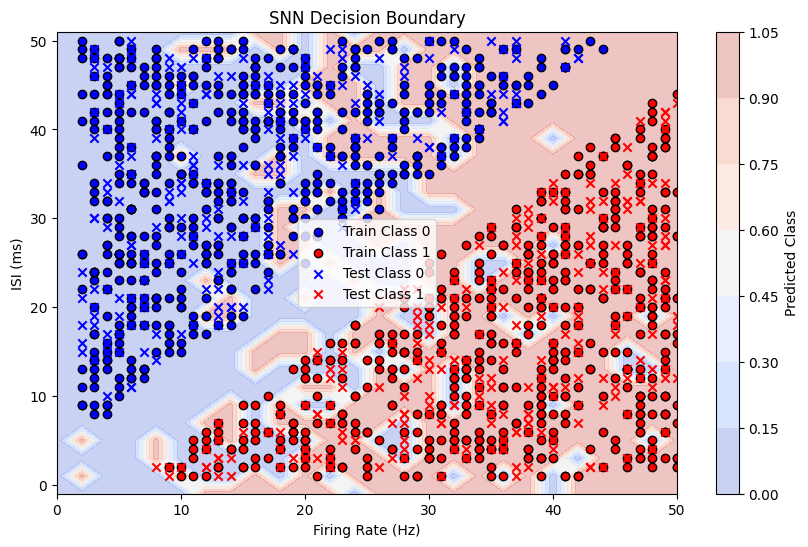

In [23]:
visualize_decision_boundary(
    net=net,
    device=device,
    train_indices=train_indices,
    test_indices=test_indices,
    firing_rates=firing_rates,
    isis=isis,
    y=y,
    step_size=2,
    T=500,
    num_neurons=10
)


接着研究部分破坏时序信息

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=50):
    """
    Partially randomize a single spike_train (shape [num_neurons, T]):
    f in [0,1] represents the randomization ratio:
    - Each spike is placed at a new random time with probability f, otherwise keep the original time.
    """
    num_neurons, T = spike_train.shape
    new_train = np.zeros_like(spike_train)

    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]

        for old_t in spike_times:
            if np.random.rand() < f:
                placed = False
                for _ in range(max_attempts):
                    new_t = np.random.randint(0, T)
                    if new_train[neuron_idx, new_t] == 0:
                        new_train[neuron_idx, new_t] = 1
                        placed = True
                        break
            else:
                new_train[neuron_idx, old_t] = 1

    return new_train

def partial_randomize_dataset(spike_trains_dataset, f=0.5, max_attempts=50):
    """
    Partially randomize the entire dataset (shape [N, num_neurons, T]).
    Returns a new perturbed dataset with the same shape as the original.
    """
    N, num_neurons, T = spike_trains_dataset.shape
    new_dataset = np.zeros_like(spike_trains_dataset)

    for i in range(N):
        new_dataset[i] = partial_randomize_spike_train(
            spike_trains_dataset[i], f=f, max_attempts=max_attempts
        )
    return new_dataset

def visualize_partial_randomization(spike_trains_per_sample,
                                   f=0.1,
                                   num_samples_to_plot=2,
                                   random_seed=42):
    """
    Visualization: Compare the same batch of samples before and after the timing perturbation.
    spike_trains_per_sample: [N, num_neurons, T]
    f: the proportion of partially disrupted timing (0~1)
    num_samples_to_plot: how many samples to visualize
    random_seed: used to fix the randomly selected samples for visualization so that it can be reproduced
    """

    # 1) Fixed random seed to ensure consistent samples
    np.random.seed(random_seed)

    N = len(spike_trains_per_sample)
    # 2) Randomly select several samples
    sample_indices = np.random.choice(N, size=num_samples_to_plot, replace=False)

    # 3) Partially perturb the entire dataset
    randomized_data = partial_randomize_dataset(spike_trains_per_sample, f=f)

    # 4) Visualize and compare the same sample: original vs. perturbed
    fig, axes = plt.subplots(num_samples_to_plot, 2,
                             figsize=(12, 3*num_samples_to_plot),
                             sharex=True, sharey=True)
    fig.suptitle(f'Compare Original vs. Partial-Randomized (f={f}) Spike Trains', fontsize=16)

    for i, sample_idx in enumerate(sample_indices):
        original_st   = spike_trains_per_sample[sample_idx]   # shape [num_neurons, T]
        randomized_st = randomized_data[sample_idx]

        ax_left  = axes[i, 0]
        ax_right = axes[i, 1]

        # (a) Original pulse sequence
        for neuron_idx in range(original_st.shape[0]):
            spike_times = np.where(original_st[neuron_idx] == 1)[0]
            ax_left.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                            s=5, color='b', marker='.')
        ax_left.set_ylabel('Neuron')
        ax_left.set_title(f'Sample {sample_idx} (Original)')

        # (b) Pulse sequence after perturbation
        for neuron_idx in range(randomized_st.shape[0]):
            spike_times = np.where(randomized_st[neuron_idx] == 1)[0]
            ax_right.scatter(spike_times, np.ones_like(spike_times)*neuron_idx,
                             s=5, color='r', marker='.')
        ax_right.set_title(f'Sample {sample_idx} (Randomized)')

        for ax in (ax_left, ax_right):
            ax.set_ylim(-1, original_st.shape[0])
            ax.grid(True)

    axes[-1, 0].set_xlabel('Time (ms)')
    axes[-1, 1].set_xlabel('Time (ms)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

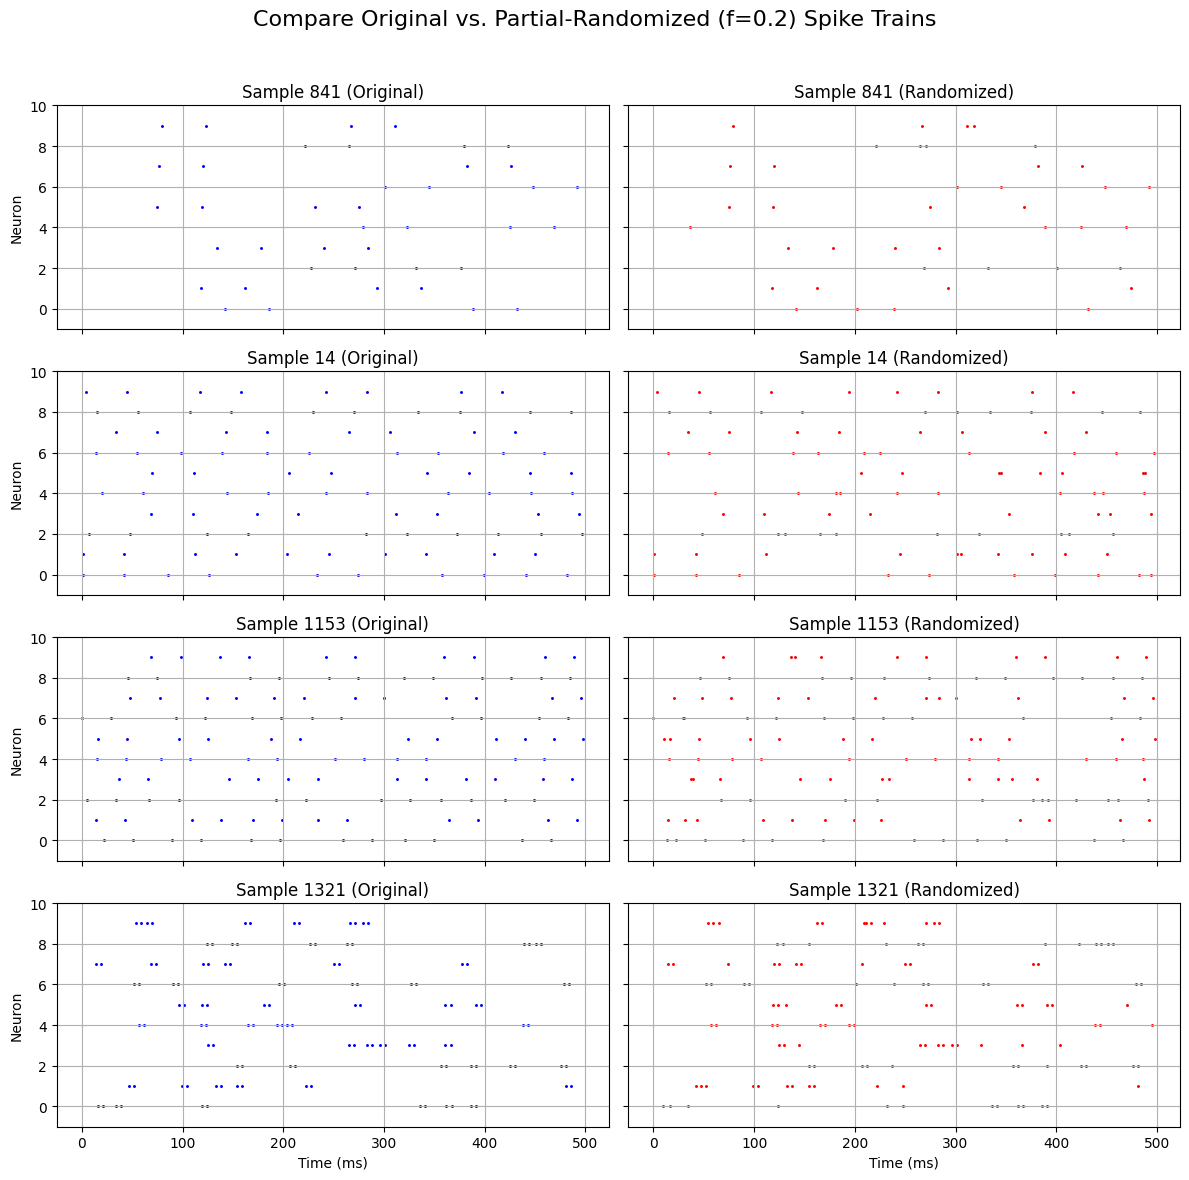

In [36]:
visualize_partial_randomization(
    spike_trains_per_sample,
    f=0.2,
    num_samples_to_plot=4,
    random_seed=2023
)

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def train_with_partial_randomization(
    f=0.5,
    device=None,
    num_epochs=50,
    lr=1e-3,
    beta=0.9,
    T=500,
    num_neurons=10,
    num_hidden=128,
    num_outputs=2,
    batch_size=16
):
    """
    1) Call init_data to get the original data set (train_st, train_lbl), (test_st, test_lbl)
    2) Perform partial randomization on the training set & test set respectively
    3) Build a new DataLoader
    4) Call train_snn to train and return the model
    """

    # ========== 1) First get the original data + Dataloader ==========
    train_loader_original, test_loader_original, T_orig, num_neurons_orig, (train_st, train_lbl), (test_st, test_lbl) = init_data(
        num_points=2000,
        radius=10,
        min_distance=1.5,
        T=T,
        num_neurons=num_neurons,
        batch_size=batch_size,
        train_split=0.7,
        seed=42
    )

    print("Original train_st shape:", train_st.shape)  # [train_size, num_neurons, T]

    # ========== 2) Perturb train_st and test_st respectively ==========
    train_st_random = partial_randomize_dataset(train_st, f=f)
    test_st_random  = partial_randomize_dataset(test_st,  f=f)

    # ========== 3) Rebuild a new DataLoader ==========
    class SpikeDataset(Dataset):
        def __init__(self, spike_trains, labels):
            self.spike_trains = spike_trains
            self.labels = labels
        def __len__(self):
            return len(self.spike_trains)
        def __getitem__(self, idx):
            st = self.spike_trains[idx]
            lbl = self.labels[idx]
            st = torch.tensor(st, dtype=torch.float32)
            lbl = torch.tensor(lbl, dtype=torch.long)
            return st, lbl

    train_dataset_rand = SpikeDataset(train_st_random, train_lbl)
    test_dataset_rand  = SpikeDataset(test_st_random,  test_lbl)

    train_loader_rand = DataLoader(train_dataset_rand, batch_size=batch_size, shuffle=True)
    test_loader_rand  = DataLoader(test_dataset_rand,  batch_size=batch_size, shuffle=False)

    # ========== 4) Call train_snn to train on the perturbed data ==========
    net = train_snn(
        train_loader=train_loader_rand,
        test_loader=test_loader_rand,
        T=T, num_neurons=num_neurons,
        num_hidden=num_hidden, num_outputs=num_outputs,
        beta=beta, lr=lr,
        num_epochs=num_epochs,
        device=device
    )

    return net

In [40]:
# Train a model on the partially perturbed dataset at f=0.1
model_f01 = train_with_partial_randomization(f=0.1, num_epochs=30)

Spike Trains Shape: (1604, 10, 500)
Original train_st shape: (1122, 10, 500)
Training on cuda
Epoch 1/30, Train Loss: 0.6224, Train Acc: 65.14%, Test Loss: 0.5940, Test Acc: 71.37%
Epoch 2/30, Train Loss: 0.6062, Train Acc: 70.51%, Test Loss: 0.5608, Test Acc: 75.60%
Epoch 3/30, Train Loss: 0.5617, Train Acc: 73.15%, Test Loss: 0.5351, Test Acc: 76.41%
Epoch 4/30, Train Loss: 0.5429, Train Acc: 73.86%, Test Loss: 0.5287, Test Acc: 77.02%
Epoch 5/30, Train Loss: 0.5463, Train Acc: 74.47%, Test Loss: 0.5027, Test Acc: 79.64%
Epoch 6/30, Train Loss: 0.5250, Train Acc: 75.62%, Test Loss: 0.5116, Test Acc: 77.02%
Epoch 7/30, Train Loss: 0.5408, Train Acc: 75.09%, Test Loss: 0.5038, Test Acc: 76.21%
Epoch 8/30, Train Loss: 0.5104, Train Acc: 75.79%, Test Loss: 0.4945, Test Acc: 79.64%
Epoch 9/30, Train Loss: 0.5041, Train Acc: 75.79%, Test Loss: 0.4898, Test Acc: 78.63%
Epoch 10/30, Train Loss: 0.4944, Train Acc: 77.55%, Test Loss: 0.4701, Test Acc: 80.24%
Epoch 11/30, Train Loss: 0.4708, Tr

In [41]:
# Train a model on the half perturbed dataset at f=0.5
model_f05 = train_with_partial_randomization(f=0.5, num_epochs=30)

Spike Trains Shape: (1604, 10, 500)
Original train_st shape: (1122, 10, 500)
Training on cuda
Epoch 1/30, Train Loss: 0.6187, Train Acc: 65.93%, Test Loss: 0.6201, Test Acc: 66.94%
Epoch 2/30, Train Loss: 0.6162, Train Acc: 71.13%, Test Loss: 0.6040, Test Acc: 67.54%
Epoch 3/30, Train Loss: 0.5554, Train Acc: 73.94%, Test Loss: 0.6028, Test Acc: 69.56%
Epoch 4/30, Train Loss: 0.5347, Train Acc: 74.56%, Test Loss: 0.5673, Test Acc: 71.98%
Epoch 5/30, Train Loss: 0.5179, Train Acc: 75.88%, Test Loss: 0.5434, Test Acc: 74.19%
Epoch 6/30, Train Loss: 0.5115, Train Acc: 76.67%, Test Loss: 0.5312, Test Acc: 75.60%
Epoch 7/30, Train Loss: 0.5065, Train Acc: 76.94%, Test Loss: 0.5103, Test Acc: 78.23%
Epoch 8/30, Train Loss: 0.4776, Train Acc: 77.55%, Test Loss: 0.5086, Test Acc: 77.42%
Epoch 9/30, Train Loss: 0.5027, Train Acc: 76.14%, Test Loss: 0.4978, Test Acc: 75.60%
Epoch 10/30, Train Loss: 0.5065, Train Acc: 76.41%, Test Loss: 0.5270, Test Acc: 75.40%
Epoch 11/30, Train Loss: 0.4799, Tr

In [43]:
# Train a model with f=0.8 (highly randomized timing)
model_f08 = train_with_partial_randomization(f=0.8, num_epochs=30)

Spike Trains Shape: (1604, 10, 500)
Original train_st shape: (1122, 10, 500)
Training on cuda
Epoch 1/30, Train Loss: 0.6315, Train Acc: 64.44%, Test Loss: 0.5930, Test Acc: 68.35%
Epoch 2/30, Train Loss: 0.5915, Train Acc: 70.16%, Test Loss: 0.6072, Test Acc: 69.76%
Epoch 3/30, Train Loss: 0.5543, Train Acc: 73.15%, Test Loss: 0.5418, Test Acc: 73.79%
Epoch 4/30, Train Loss: 0.5272, Train Acc: 75.53%, Test Loss: 0.5383, Test Acc: 72.98%
Epoch 5/30, Train Loss: 0.5208, Train Acc: 75.79%, Test Loss: 0.5329, Test Acc: 74.80%
Epoch 6/30, Train Loss: 0.5090, Train Acc: 76.32%, Test Loss: 0.5418, Test Acc: 73.79%
Epoch 7/30, Train Loss: 0.5032, Train Acc: 76.41%, Test Loss: 0.5242, Test Acc: 75.60%
Epoch 8/30, Train Loss: 0.4911, Train Acc: 76.76%, Test Loss: 0.4904, Test Acc: 76.61%
Epoch 9/30, Train Loss: 0.4897, Train Acc: 78.17%, Test Loss: 0.5196, Test Acc: 76.81%
Epoch 10/30, Train Loss: 0.4953, Train Acc: 77.38%, Test Loss: 0.4942, Test Acc: 77.02%
Epoch 11/30, Train Loss: 0.4995, Tr

In [44]:
# Train a model with f=1.0 (completely randomized timing)
model_f10 = train_with_partial_randomization(f=1.0, num_epochs=30)

Spike Trains Shape: (1604, 10, 500)
Original train_st shape: (1122, 10, 500)
Training on cuda
Epoch 1/30, Train Loss: 0.6398, Train Acc: 64.35%, Test Loss: 0.5853, Test Acc: 69.56%
Epoch 2/30, Train Loss: 0.6171, Train Acc: 69.54%, Test Loss: 0.5551, Test Acc: 74.80%
Epoch 3/30, Train Loss: 0.5757, Train Acc: 72.54%, Test Loss: 0.5506, Test Acc: 73.59%
Epoch 4/30, Train Loss: 0.5137, Train Acc: 75.44%, Test Loss: 0.5279, Test Acc: 76.41%
Epoch 5/30, Train Loss: 0.5163, Train Acc: 75.70%, Test Loss: 0.5182, Test Acc: 77.02%
Epoch 6/30, Train Loss: 0.5001, Train Acc: 76.85%, Test Loss: 0.5026, Test Acc: 75.60%
Epoch 7/30, Train Loss: 0.5001, Train Acc: 75.70%, Test Loss: 0.4967, Test Acc: 77.62%
Epoch 8/30, Train Loss: 0.4868, Train Acc: 76.76%, Test Loss: 0.4911, Test Acc: 77.82%
Epoch 9/30, Train Loss: 0.4812, Train Acc: 77.55%, Test Loss: 0.4865, Test Acc: 79.03%
Epoch 10/30, Train Loss: 0.4934, Train Acc: 76.94%, Test Loss: 0.5046, Test Acc: 78.23%
Epoch 11/30, Train Loss: 0.4774, Tr

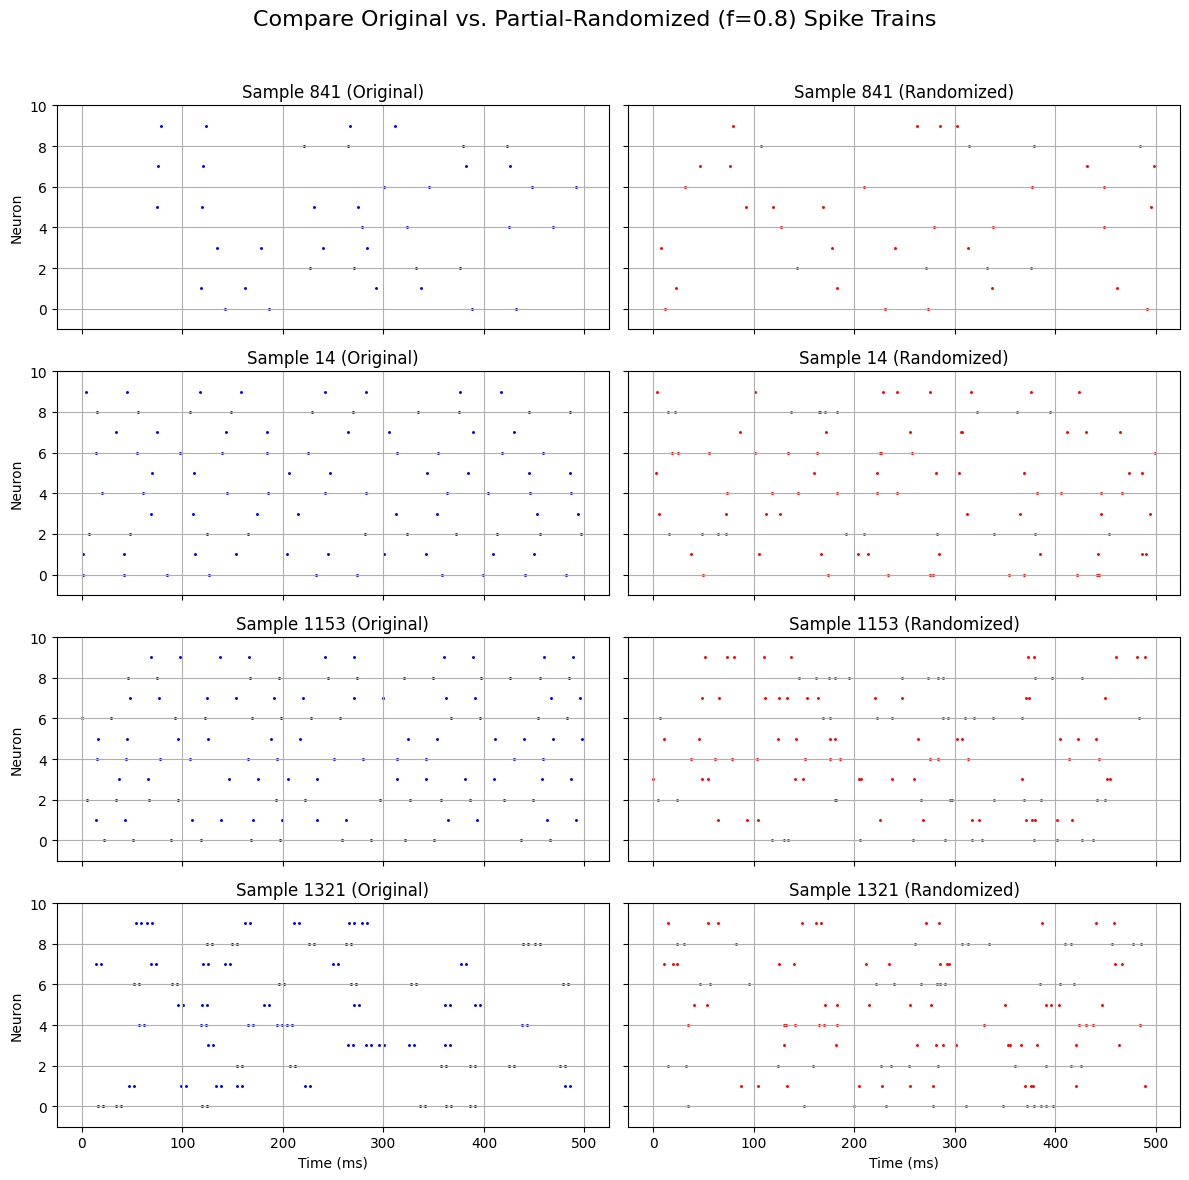

In [47]:
visualize_partial_randomization(
    spike_trains_per_sample,
    f=0.8,
    num_samples_to_plot=4,
    random_seed=2023
)

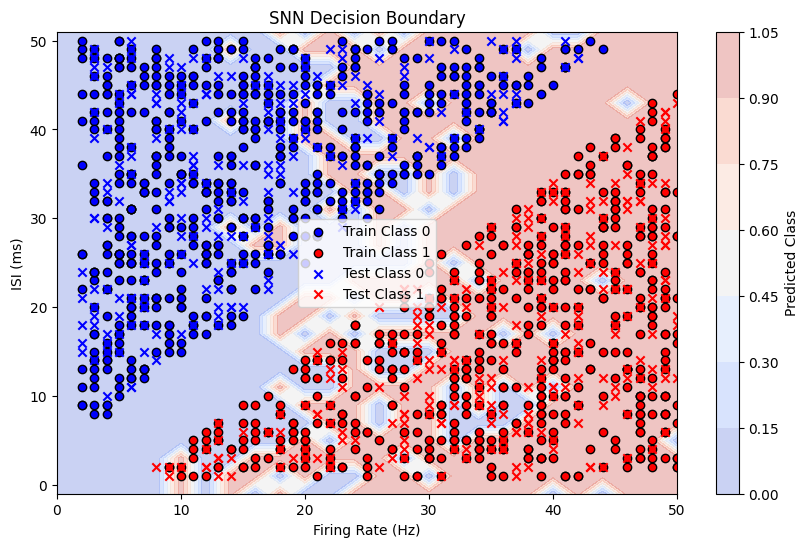

In [49]:
visualize_decision_boundary(
    net=model_f05,
    device=device,
    train_indices=train_indices,
    test_indices=test_indices,
    firing_rates=firing_rates,
    isis=isis,
    y=y,
    step_size=2,
    T=500,
    num_neurons=10
)


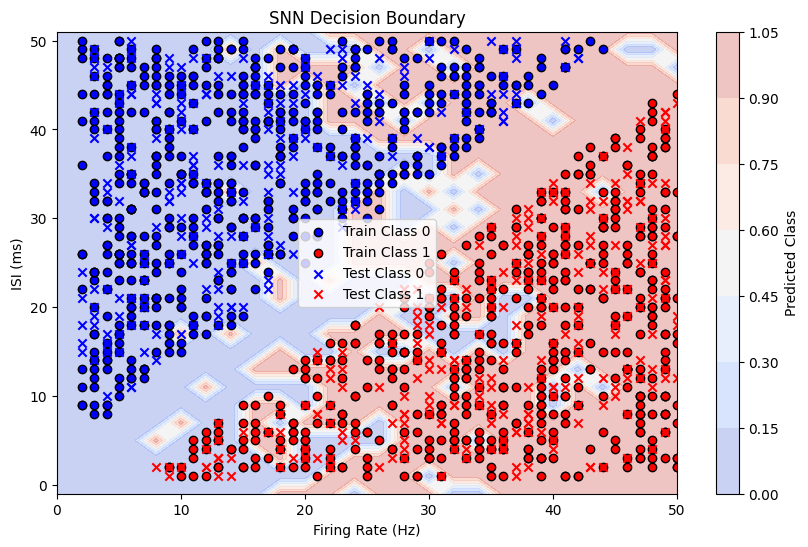

In [48]:
visualize_decision_boundary(
    net=model_f08,
    device=device,
    train_indices=train_indices,
    test_indices=test_indices,
    firing_rates=firing_rates,
    isis=isis,
    y=y,
    step_size=2,
    T=500,
    num_neurons=10
)


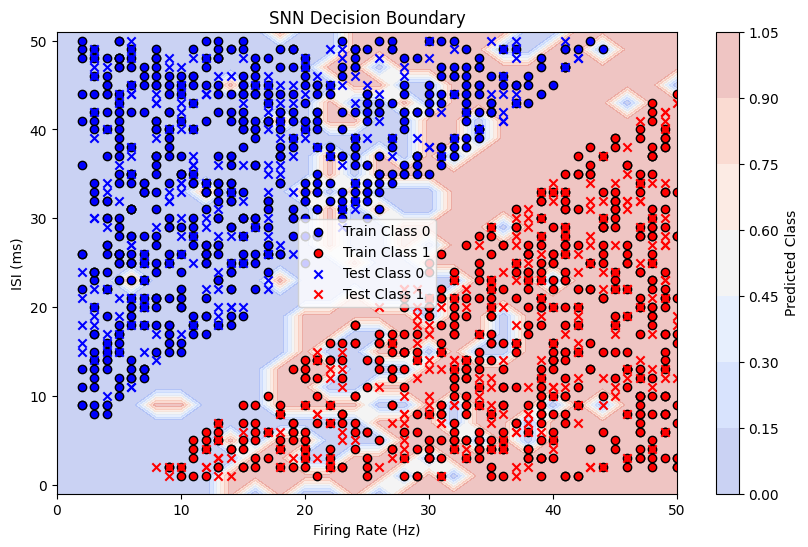

In [51]:
visualize_decision_boundary(
    net=model_f10,
    device=device,
    train_indices=train_indices,
    test_indices=test_indices,
    firing_rates=firing_rates,
    isis=isis,
    y=y,
    step_size=2,
    T=500,
    num_neurons=10
)